# **DMML HUBLOT -  2020**
## Authors: Aliou Baldé, Lorenzo Mezzini, Said Zachary

## Table of Contents
1. Introduction
2. Data uploading
3. EDA 
4. Text cleaning
5. Results and discussion
6. Classification: Improvements with Logistic Regression
7. Conclusion  
8. (Appendix) Hyperparameter tuning details





## 1. Introduction

Real or Not ? NLP with disaster tweets: in this project we look forward to building a Machine learning model that is capable of predicting if a tweet is a about a real or fake disaster. 

The data comes from a Kaggle competition. 

Several deliverables are demanded for this project. In this notebook you will find our Machine learning model code. As required, we will present a comparison of different classsifiers: Logistic regression, kNN, Decision trees, Random forest.

The remaining notebook is organised as follows. We start with EDA (Exploratory Data Analysis) to get familiar with the dataset, to generate insight and to discover underlying hidden patterns in the dataset. We continue with Data cleaning and text preprocessing to get our data ready for classification. Different classification techniques are subsquently developped with Feature engineering and Hyper-parameter optimization. We also present and discuss our results.


LET US HAVE A LITTLE BIT OF FUN!

## 2. Data uploading

In [15]:
#@title ### 2.1 Importing the necessary packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import spacy 
import string
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import re
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import spacy as sp
import string
import re
import IPython
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from time import process_time 
from sklearn import preprocessing

In [ ]:
#@title 2.2 Upload the data
# Import the data
df_train = pd.read_csv('https://raw.githubusercontent.com/zsgithub2/Hublot-project/main/Data/training_data.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/zsgithub2/Hublot-project/main/Data/test_data.csv')

## 3. EDA

### 3.1 Basic EDA

In [ ]:
#@title Packages
import seaborn as sns
import re
import gensim
plt.style.use('ggplot')
%matplotlib inline
sns.set_style("whitegrid")

In [ ]:
#@title Shape of the data { vertical-output: true }
print('There are {} rows and {} columns in train dataset'.format(df_train.shape[0],df_train.shape[1]))
print('There are {} rows and {} columns in test dataset'.format(df_test.shape[0],df_test.shape[1]))

There are 6471 rows and 5 columns in train dataset
There are 1142 rows and 4 columns in test dataset


#### Dataset composision

In this dataset we have four features: 

    1- Id - the id of the tweet
    2- Keyword - A keyword associated to the tweet
    3- Location - The location 
    4- Text - the message body

And one target variable.

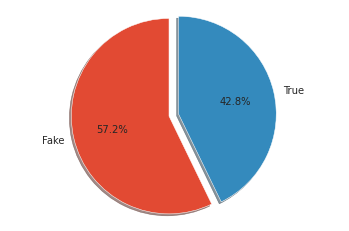

The base rate is: 0.572%


In [ ]:
#@title ### 3.1 Base rate { vertical-output: true }

sizes = [max(df_train.groupby('target')['id'].count())/len(df_train),min(df_train.groupby('target')['id'].count())/len(df_train)]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=['Fake','True'], autopct='%1.1f%%',shadow = True, startangle=90)
ax1.axis('equal')  
plt.show()
print('The base rate is: ' + str(round( max(df_train.groupby('target')['id'].count())/len(df_train),3)) + '%')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Number of observations')

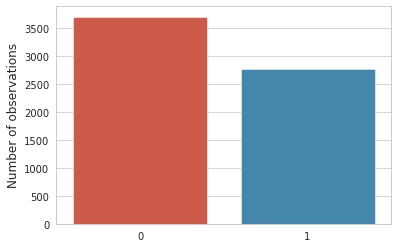

In [ ]:
#@title 3.2 Number of observation in per target  
classes=df_train.target.value_counts()
sns.barplot(classes.index,classes)
plt.gca().set_ylabel('Number of observations')

So far, we see that our training data set is unbalanced. We have slightly less "Real news" than "Fake news". Let us proceed with the analysis of the keywords.

In [ ]:
#@title Most common keywords associated to fake news { vertical-output: true }
# First we clean the %20's
df_train['keyword'] = df_train['keyword'].fillna('na')
df_train['location'] = df_train['location'].fillna('na')

for i in range(len(df_train['keyword'])):
    df_train['keyword'][i] = re.sub('%20',' ', df_train['keyword'][i])

# Then we divide the data in the two groups
df_true = df_train[df_train['target'] == 1]
df_fake = df_train[df_train['target'] == 0]
kword_true = df_true.groupby('keyword')['id'].nunique()
kword_fake = df_fake.groupby('keyword')['id'].nunique()
kword_fake.sort_values(ascending = False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


keyword
body bags          33
deluge             33
harm               33
aftershock         32
twister            31
                   ..
bombing             2
rescuers            1
oil spill           1
suicide bomber      1
suicide bombing     1
Name: id, Length: 217, dtype: int64

Let us plot it.

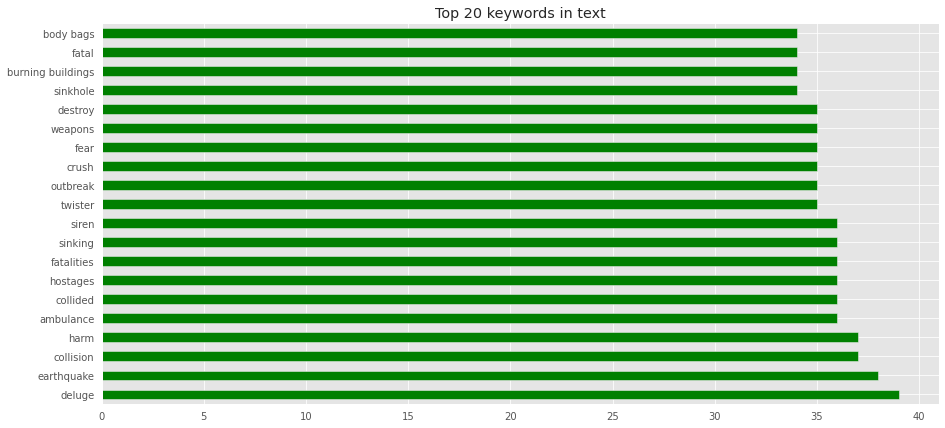

In [ ]:
#@title Graph
plt.style.use('ggplot')
df_train.keyword.value_counts()[1:21].plot(kind='barh', figsize=(15,7) ,title='Top 20 keywords in text', color='green')

What about locations?

In [ ]:
#@title Most common locations { vertical-output: true }
loc_true = df_true.groupby('location')['id'].nunique()
loc_fake = df_fake.groupby('location')['id'].nunique()
loc_fake.sort_values(ascending = False)

location
na                       1230
New York                   47
USA                        33
London                     25
United States              21
                         ... 
San Diego, California       1
San Diego, Texas.           1
San Jose                    1
San Jose, California        1
  Glasgow                   1
Name: id, Length: 1866, dtype: int64

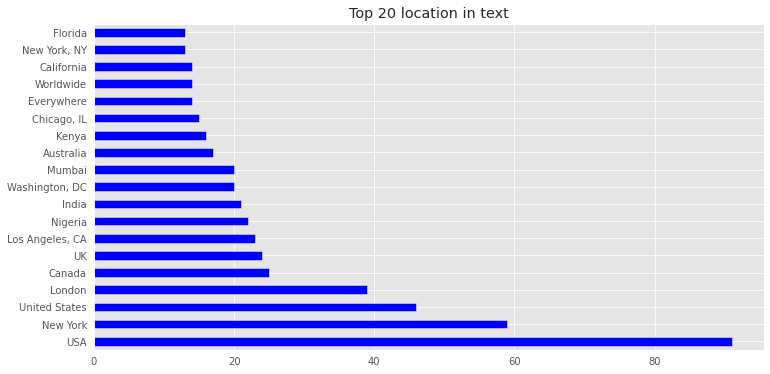

In [ ]:
#@title Graph
plt.style.use('ggplot')
df_train.location.value_counts()[1:20].plot(kind='barh', figsize = (12,6), title='Top 20 location in text', color='blue')

### 3.2 Wordclouds

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


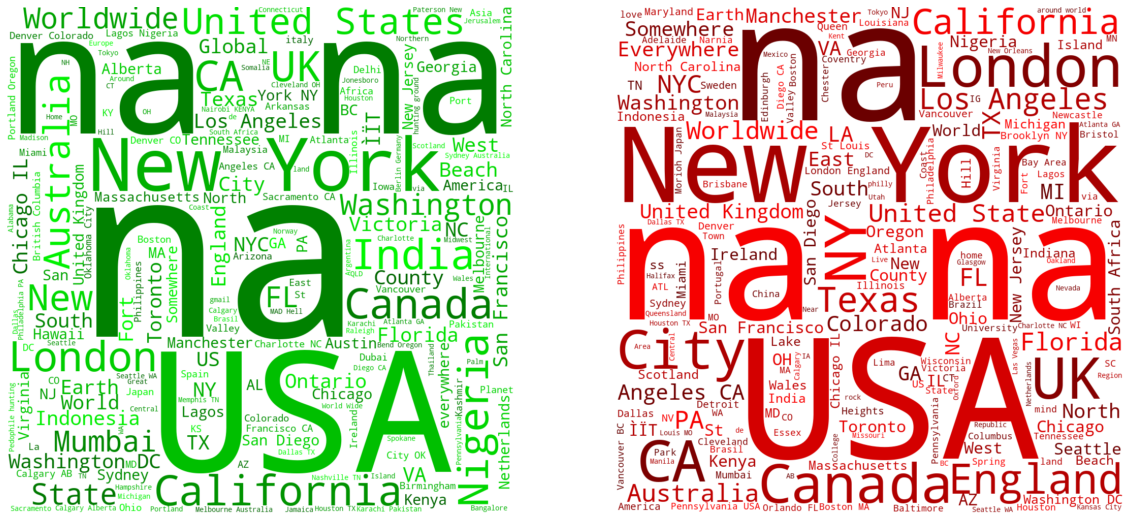

In [ ]:
#@title Location wordcloud per target { vertical-output: true }
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import random
df_true['location']= df_true['location'].fillna('na')
df_fake['location']= df_fake['location'].fillna('na')
all_loc_true =[]
all_loc_fake =[]

for text in df_true['location']:
    all_loc_true.append(text)
all_loc_true = " ".join(all_loc_true)

for text in df_fake['location']:
    all_loc_fake.append(text)
all_loc_fake = " ".join(all_loc_fake)

def color_func1(word, font_size, position, orientation, random_state=None,**kwargs):
    return "rgb(0, %d, 0)" % random.randint(100, 255)

def color_func2(word, font_size, position, orientation, random_state=None,**kwargs):
    return "rgb(%d, 0, 0)" % random.randint(100, 255)

#creating wordcloud
wordcloud_true = WordCloud(width=1000, height=1000, contour_color="black", max_words=200, relative_scaling = 0, background_color = "white").generate(all_loc_true)
wordcloud_fake = WordCloud(width=1000, height=1000, contour_color="black", max_words=200, relative_scaling = 0, background_color = "white").generate(all_loc_fake)

fig = plt.figure(figsize=(20, 40))

fig.add_subplot(1, 2, 1)
plt.imshow(wordcloud_true.recolor(color_func= color_func1), interpolation="bilinear")
plt.axis("off")
fig.add_subplot(1, 2, 2)
plt.imshow(wordcloud_fake.recolor(color_func= color_func2), interpolation="bilinear")
plt.axis("off")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


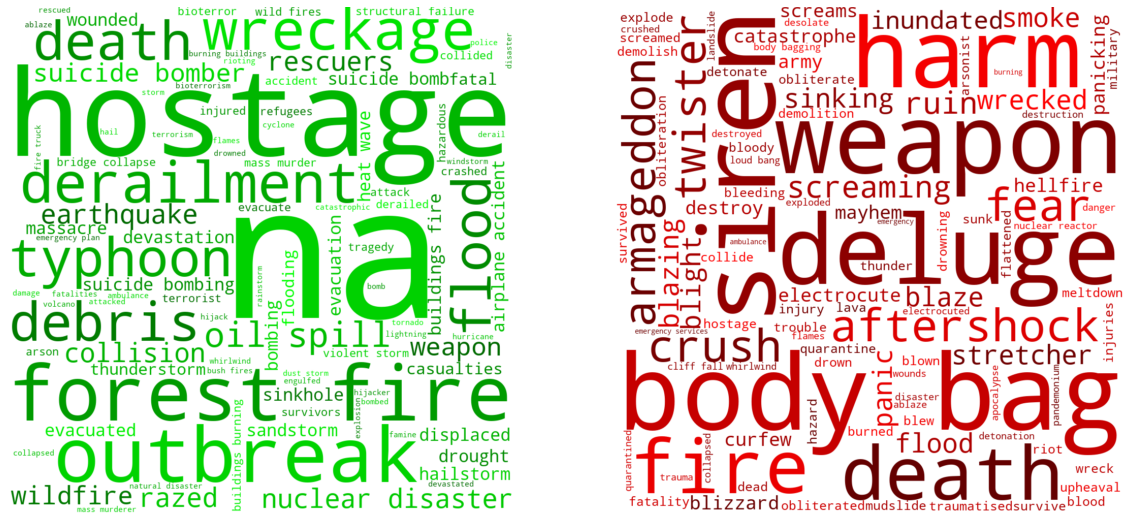

In [ ]:
#@title Keywords wordcloud per target
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import random
df_true['keyword']= df_true['keyword'].fillna('na')
df_fake['keyword']= df_fake['keyword'].fillna('na')

all_key_true =[]
all_key_fake =[]

for text in df_true['keyword']:
    all_key_true.append(text)
all_key_true = " ".join(all_key_true)

for text in df_fake['keyword']:
    all_key_fake.append(text)
all_key_fake = " ".join(all_key_fake)

def color_func1(word, font_size, position, orientation, random_state=None,**kwargs):
    return "rgb(0, %d, 0)" % random.randint(100, 255)

def color_func2(word, font_size, position, orientation, random_state=None,**kwargs):
    return "rgb(%d, 0, 0)" % random.randint(100, 255)

#creating wordcloud
wordcloud_true = WordCloud(width=1000, height=1000, contour_color="black", max_words=100, relative_scaling = 0, background_color = "white").generate(all_key_true)
wordcloud_fake = WordCloud(width=1000, height=1000, contour_color="black", max_words=100, relative_scaling = 0, background_color = "white").generate(all_key_fake)

fig = plt.figure(figsize=(20, 40))

fig.add_subplot(1, 2, 1)
plt.imshow(wordcloud_true.recolor(color_func= color_func1), interpolation="bilinear")
plt.axis("off")
fig.add_subplot(1, 2, 2)
plt.imshow(wordcloud_fake.recolor(color_func= color_func2), interpolation="bilinear")
plt.axis("off")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning:

invalid value encountered in greater_equal

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning:

invalid value encountered in greater_equal

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning:

invalid value encountered in less_equal



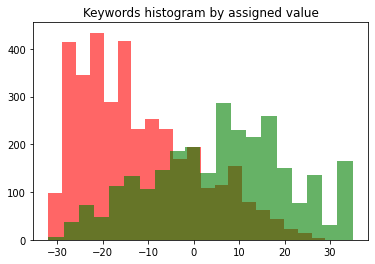

In [ ]:
keywords = df_train.groupby('keyword')['id'].nunique().index.values

key_count = []
for key in keywords:
    val = 0
    for i in range(len(df_train[df_train['keyword'] == key])):
        if (df_train[df_train['keyword'] == key]['target'].reset_index(drop = True)[i] == 1):
            val = val + 1
        else: val = val - 1
    key_count.append(val)
key_values = pd.DataFrame(key_count, index = keywords.tolist(), columns=['score'])

for i in range(len(key_values)):
    df_train['keyword'][df_train['keyword'] == keywords[i]] = key_values['score'][i]

plt.hist(df_train[df_train['target']==0]['keyword'], alpha = .6, color = 'red', bins= 20)
plt.hist(df_train[df_train['target']==1]['keyword'], alpha = .6, color = 'green', bins= 20)
plt.title('Keywords by assigned value')

plt.show()

Here we attribute a score to keywords depending on their frequency in real and fake disaster tweets. The histogram above shows the number of keywords per assigned value. We see that keywords for real disasters (green bars) are assigned higher values on average than keywords for fake disasters. This indicates that the keywords contain information to discriminate between real and fake disasters.

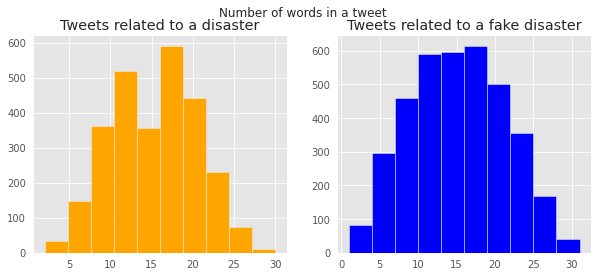

In [ ]:
#@title Number of words in a tweet
from collections import defaultdict
from collections import  Counter
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
lenght=df_train[df_train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(lenght,color='orange')
ax1.set_title('Tweets related to a disaster')
lenght = df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(lenght,color='blue')
ax2.set_title('Tweets related to a fake disaster')
fig.suptitle('Number of words in a tweet')
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


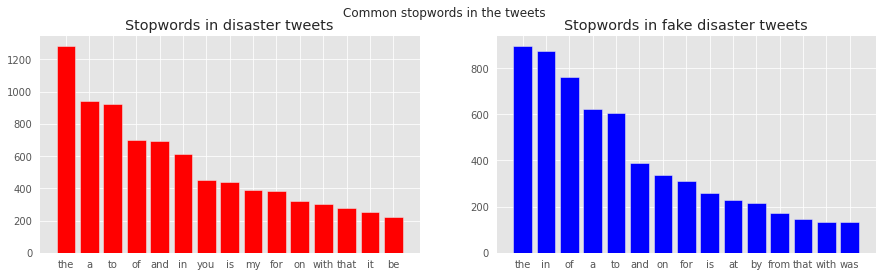

In [ ]:
#@title Most common stopwords
import en_core_web_sm
nlp = en_core_web_sm.load()
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

punctuations = string.punctuation

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


sp = en_core_web_sm.load()
spacy_st = nlp.Defaults.stop_words
nltk_st = stopwords.words('english')
def Common_stop(target):
    list_stop=[]
    
    for x in df_train[df_train['target']==target]['text'].str.split():
        for i in x:
            list_stop.append(i)
    return list_stop

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,4))

list_stop_fake=Common_stop(0)

dic=defaultdict(int)
for word in list_stop_fake:
    if word in nltk_st:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15] 
x,y=zip(*top)
ax1.bar(x, y,color='red')
ax1.set_title('Stopwords in disaster tweets')

list_stop_real=Common_stop(1)

dic=defaultdict(int)
for word in list_stop_real:
    if word in nltk_st:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15] 
x,y=zip(*top)
ax2.bar(x, y,color='blue')
ax2.set_title('Stopwords in fake disaster tweets')

fig.suptitle('Common stopwords in the tweets')
plt.show()

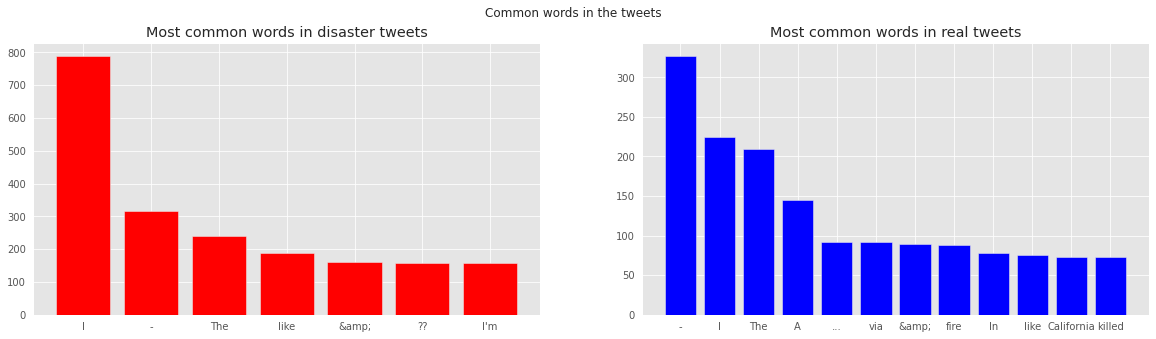

In [ ]:
#@title Most common words in our sample before cleaning
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))

list_stop_fake=Common_stop(0)
counter=Counter(list_stop_fake)
most=counter.most_common()
x=[]
y=[]
for word, count in most[:40]:
    if (word not in nltk_st) :
        x.append(word)
        y.append(count)

ax1.bar(x, y,color='red')
ax1.set_title('Most common words in disaster tweets')

list_stop_real=Common_stop(1)
counter=Counter(list_stop_real)
most=counter.most_common() 

x=[]
y=[]
for word, count in most[:40]:
    if (word not in nltk_st) :
        x.append(word)
        y.append(count)

ax2.bar(x, y,color='blue')
ax2.set_title('Most common words in real tweets')

fig.suptitle('Common words in the tweets')
plt.show()

In [ ]:
#@title Comparison of text lenght using a box plot
import plotly.graph_objects as go
df_train['text_lenght'] = df_train['text'].apply(len)
data = [
    go.Box(
        y=df_train[df_train['target']==0]['text_lenght'],
        name='Fake'
    ),
    go.Box(
        y=df_train[df_train['target']==1]['text_lenght'],
        name='Real'
    )
]
layout = go.Layout(
    title = 'Comparison of text length in Tweets '
)
plt = go.Figure(data=data, layout=layout)
plt.show()

### 3.4 EDA using Sweetviz

In [ ]:
import IPython
! pip install sweetviz

In [ ]:
import sweetviz as sv
report = sv.compare([df_train, "Training Data"], [df_test, "Test Data"])
report.show_html('analyze.html', open_browser = False)

In [ ]:
IPython.display.HTML('analyze.html')

## 4. Text cleaning

We start by defining some text cleaning functions to remove hashtags, links, emojis, punctuation, incorrect spelling and replace abbreviations with original words. 

In [ ]:
#@title Code for cleaning { display-mode: "form" }
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
     "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
     "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
     "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
        "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word
def convert_abbrev_in_text(text):
    tokens = [text]
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [ ]:
# import cleaned tweets
df_clean_train = pd.read_csv('https://raw.githubusercontent.com/zsgithub2/Hublot-project/main/Data/cleantrain.csv')
df_clean_test = pd.read_csv('https://raw.githubusercontent.com/zsgithub2/Hublot-project/main/Data/cleantest.csv')

In [ ]:
print('original tweet:', df_train['text'][1])
print('clean tweet', df_clean_train['key_text'][1])

#world FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps  http://t.co/5zDbTktwW7
bioterror world FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps


In [ ]:
# 80/20 Test (Run this to get an Idea of how good is the program)
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(df_clean_train['key_text'], df_clean_train['target'], test_size=0.2, random_state=72)

In [ ]:
X_train_clean = X_train_clean.astype(str)
X_test_clean = X_test_clean.astype(str)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define vectorizer
tfidf = TfidfVectorizer(sublinear_tf= True, ngram_range=(1,2))
count = CountVectorizer(ngram_range=(1,2))
# Fit and transform X_train and X_test
X_train_vec = tfidf.fit_transform(X_train_clean).toarray()
X_test_vec = tfidf.transform(X_test_clean).toarray()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time

# Define Model
pipe = Pipeline([
                 ('logistic reg', LogisticRegressionCV(Cs = 10, solver="lbfgs",cv = 5, max_iter=2000, random_state=72))
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train_clean)
end = time.time()
print('Time: ', round(end-start, 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test_clean), 4))

Time:  2105.6834
Test Accuracy:  0.8031


## 5. Results and discussion

### 5.1 Summary table and graph of the different techniques used

#### A.1- Table: classifier comparison

| Classifier                                    | 80/20 Test accuracy | Parameters used                                                                         |
|-----------------------------------------------|:-------------------:|-----------------------------------------------------------------------------------------|
| Logistic   Regression                         |        0.8077       | {'C': 1, 'solver': 'lbfgs'}                                                             |
| Random Forest                                 |        0.7768       | {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}                         |
| Logistic Regression + Standardization         |        0.7714       | {'C': 1, 'solver': 'lbfgs'}                                                             |
| Logistic Regression + PCA +   Standardization |        0.7691       | {'C': 1, 'solver': 'lbfgs'}                                                             |                                             |
| Decision Tree                                 |        0.7544       | {'criterion': 'gini', 'max_depth': None, 'max_features': None} |
| Logistic Regression + PCA                     |        0.7529       | {'C': 1, 'solver': 'lbfgs'}              
| k-Nearest Neighbors                           |        0.7158       | {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}                       |

#### A.2- Table: submission track

| 80/20 test 	| AI crowd 	| Technique                                                                                                                                                                	|
|------------	|----------	|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| 0.794      	| 0.80998  	| Text analysis + LogRegCV only   (random state 72, CV=5)                                                                                                                    	|
| 0.8077     	| 0.82311  	| Text analysis + LogRegCV + Keywords in Text (random state 72, CV=5)                                                                                                      	|
| 0.8015     	| 0.82137  	| Text analysis + LogRegCV + little changes in stopwords + 2 ngrams (random   state 72, CV=5)                                                                              	|
| 0.809      	| 0.818    	| Key, hashtags, 2-ngrams, no cv (random state 72)                                                                                                                         	|
| 0.813      	| 0.807    	| Key, hashtags, 2-ngrams, no cv (random state 72)                                                                                                                         	|
| 0.8        	| 0.815236 	| logistic reg + grid search (C= 1.20679) + using text feature + TF   IDF  2-gram                                                                                          	|
| 0.801544   	| 0.813448 	| logistic reg + grid search (C= 1.20679) + using key text feature + TF IDF   2-grams                                                                                      	|
| 0.805405   	| 0.823118 	| logistic reg + grid search (C= 0.5689866) + using text feature + TF IDF   2-grams +  basic cleaning only                                                                 	|
| 0.806178   	| NA       	| logistic reg + grid search (C= 0.5689866) + using text feature + TF IDF   2-grams + target update + basic cleaning only using spacy tokenizer                            	|
| 0.807722   	| NA       	| logistic reg + grid search (C= 0.5689866) + using text feature + TF IDF   2-grams + target update + basic cleaning only using spacy tokenizer +   stopwords optimization 	|
| 0.809266   	| NA       	| logistic reg + grid search (C= 0.5689866) + using text feature + TF IDF   2-grams + target update + basic cleaning only using spacy tokenizer +   stopwords optimization 	|

#### B- Graph

In [ ]:
submission_data = pd.read_csv('https://raw.githubusercontent.com/zsgithub2/Hublot-project/main/Data/submission_track.csv')

Text(0.5, 1.0, 'Accuracies in the 80/20 test')

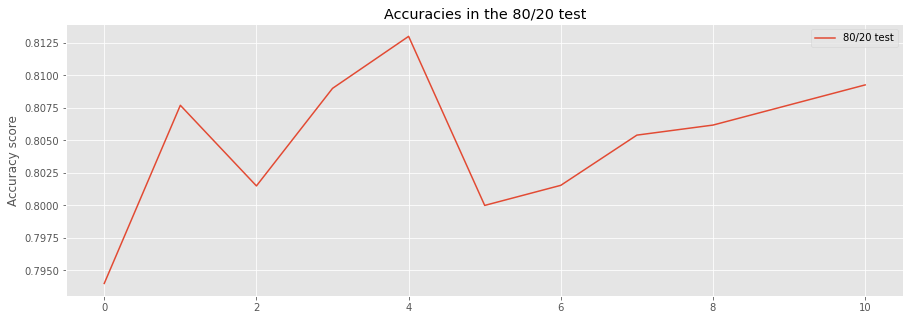

In [ ]:
plt.style.use('ggplot')
submission_data.plot(kind='line',y='80/20 test', figsize=(15,5))
plt.ylabel('Accuracy score')
plt.title('Accuracies in the 80/20 test')

In [ ]:
submission_data

,80/20 test,AI crowd,Technique
0,0.794000,0.809980,"Text analysis LogRegCV only (random state 72, ..."
1,0.807700,0.823110,Text analysis + LogRegCV + Keywords in Text (r...
2,0.801500,0.821370,Text analysis + LogRegCV + little changes in s...
3,0.809000,0.818000,"Key, hashtags, 2-ngrams, no cv (random state 72)"
4,0.813000,0.807000,"Key, hashtags, 2-ngrams, no cv (random state 72)"
5,0.800000,0.815236,logistic reg + grid search (C= 1.20679) + usin...
6,0.801544,0.813448,logistic reg + grid search (C= 1.20679) + usin...
7,0.805405,0.823118,logistic reg + grid search (C= 0.5689866) + us...
8,0.806178,NaN,logistic reg + grid search (C= 0.5689866) + us...
9,0.807722,NaN,logistic reg + grid search (C= 0.5689866) + us...


Text(0.5, 1.0, 'Accuracies in AI Crowd')

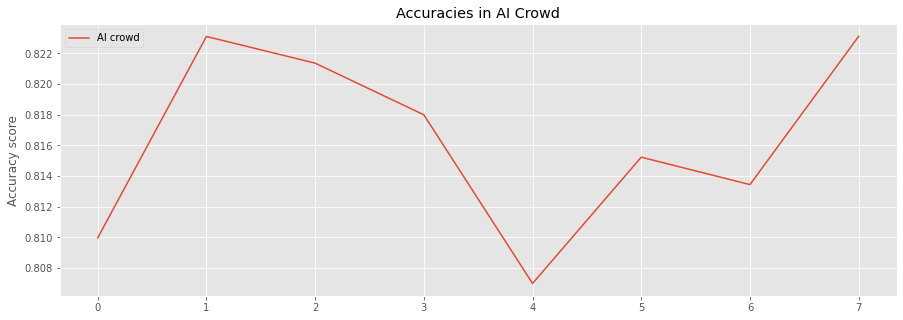

In [ ]:
plt.style.use('ggplot')
submission_data.plot(kind='line',y='AI crowd', figsize=(15,5))
plt.ylabel('Accuracy score')
plt.title('Accuracies in AI Crowd')

We tried different classification with different cleanings. We will present each one with the outcome result. 

### 5.2 DETAILS: Define classifiers with best the hyperparameters obtained using GridSearchCV and compare the test accuracy of each classifier.

In [3]:
#@title Prepare data for classification

# Import the data
df_train = pd.read_csv('https://raw.githubusercontent.com/zsgithub2/Hublot-project/main/Data/training_data.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/zsgithub2/Hublot-project/main/Data/test_data.csv')


# create a new feature that also comprehend the keyword
df_train['key_text'] = df_train['keyword'] + ' ' + df_train['text'] 
df_train['key_text'] = df_train['key_text'].astype(str)
df_test['key_text'] = df_test['keyword'] + ' ' + df_test['text'] 
df_test['key_text'] = df_test['key_text'].astype(str)


# Define tokenizer cleaner
sp = spacy.load('en_core_web_sm') 
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS 
punctuations = string.punctuation


# Tokenizer
def tokenizer(message):
    filtered_message = []  
    for sentence in message:
        processd_message = []
        sentence = sp(sentence)
        for word in sentence:
            if str(word) not in punctuations:
              if (word.is_stop == False) and (word.is_space == False):
                  processd_message.append(word.lemma_.lower())
        filtered_message.append(processd_message) 

    all_text = []
    for text_list in filtered_message:
      all_text.append(""" """.join(text_list))

    count = CountVectorizer(ngram_range=(1,1), stop_words="english")
    bow = count.fit_transform(all_text)
    feature_names = count.get_feature_names()
    df_final = pd.DataFrame(bow.todense(), columns=feature_names)

    return df_final

# 80/20 Test (Run this to get an Idea of how good is the program)
X_train, X_test, y_train, y_test = train_test_split(tokenizer(df_train['key_text']), df_train['target'], test_size=0.2, random_state=72)

In [9]:
classifiers = {
    "Logistic Regression": LogisticRegressionCV(solver="lbfgs",cv = 5, max_iter=1000, random_state=72),
    "Decision Tree": DecisionTreeClassifier(criterion= 'gini', max_depth= None),
    "k-Nearest Neighbors": KNeighborsClassifier(metric= 'euclidean', n_neighbors= 5, weights= 'distance'),
    "Random Forest": RandomForestClassifier(criterion= 'gini', max_depth= None, max_features= 'auto'),
        }

In [10]:
no_classifiers = len(classifiers.keys())

from time import process_time 


def batch_classify(X_train, X_test, y_train, y_test, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['Classifier', 'Test Accuracy', 'Training time'])
    count = 0
    for key, classifier in classifiers.items():
        t_start = process_time()  
        classifier.fit(X_train, y_train)
        t_stop = process_time() 
        t_elapsed = t_stop - t_start
        y_predicted = classifier.predict(X_test)
        
        df_results.loc[count,'Classifier'] = key
        df_results.loc[count,'Test Accuracy'] = accuracy_score(y_test, y_predicted)
        df_results.loc[count,'Training time'] = t_elapsed
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_elapsed))
        count+=1

    return df_results
df_results = batch_classify(X_train, X_test ,y_train, y_test)
print(df_results.sort_values(by='Test Accuracy', ascending=False))

trained Logistic Regression in 1319.37 s
trained Decision Tree in 65.47 s
trained k-Nearest Neighbors in 11.76 s
trained Random Forest in 79.40 s
            Classifier  Test Accuracy  Training time
0  Logistic Regression       0.807722    1319.367120
3        Random Forest       0.776834      79.401430
1        Decision Tree       0.754440      65.465996
2  k-Nearest Neighbors       0.715830      11.759610


Logistic regression appears to be best suited to the problem. We therefore focus on Logistic regression from here on out. 

Dimensionality Reduction with logisitc regression

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Define Scaler
scaler = StandardScaler()

# Define PCA
pca = PCA(n_components=100)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define vectorizer - use above cleaning function
tfidf = TfidfVectorizer(sublinear_tf= True, ngram_range=(1,2))
count = CountVectorizer(ngram_range=(1,2))
# Fit and transform X_train and X_test
X_train_vec = tfidf.fit_transform(X_train_clean).toarray()
X_test_vec = tfidf.transform(X_test_clean).toarray()

In [ ]:
# With PCA and Standardization
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time

# Define Model
pipe = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('logistic reg', LogisticRegressionCV(Cs = 10, solver="lbfgs",cv = 5, max_iter=2000, random_state=72))
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train_clean)
end = time.time()
print('Time: ', round(end-start, 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test_clean), 4))

In [ ]:
# With PCA 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time

# Define Model
pipe = Pipeline([('pca', pca),
                 ('logistic reg', LogisticRegressionCV(Cs = 10, solver="lbfgs",cv = 5, max_iter=2000, random_state=72))
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train_clean)
end = time.time()
print('Time: ', round(end-start, 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test_clean), 4))

Time:  66.5763
Test Accuracy:  0.7529


In [ ]:
# With Standardization 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time

# Define Model
pipe = Pipeline([('scaler', scaler),
                 ('logistic reg', LogisticRegressionCV(Cs = 10, solver="lbfgs",cv = 5, max_iter=2000, random_state=72))
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train_clean)
end = time.time()
print('Time: ', round(end-start, 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test_clean), 4))

Time:  2632.218
Test Accuracy:  0.7714


With PCA and standardization, we obtain lower test accuracies. We therefore stick to the logistic regression classifier without dimensionality reduction in the rest of the analysis.  

Where does the classifier fail to classify tweets correctly? Let us look at a few examples. 

In [ ]:
pred = pipe.predict(X_test_vec)
pred = pd.DataFrame(pred)
pred

,0
0,0
1,0
2,0
3,0
4,1
...,...
1290,0
1291,1
1292,0
1293,0


In [ ]:
y_test_clean

5116    0
4867    1
6465    1
1976    0
5872    0
       ..
3658    0
26      1
4409    0
2106    0
3958    0
Name: target, Length: 1295, dtype: int64

In [ ]:
df_train.iloc[6465]['text']
df_clean_train.iloc[6465]['key_text']

'rubble Chinas Stock Market Crash Are There Gems In The Rubble ROIMentor yycwalks'

Although this tweet has a target value of 1, it does not seem to be a about a real disaster. We therefore attempt to correct some target values later on. 

## 6. Classification: Improvements with Logistic Regression

### 6.1 Classification using Logistic regression CV and feature engineering - this one got us our best accuracy on Ai Crowd

In [ ]:
#@title We create new features to combine the Keyword and the text { vertical-output: true, display-mode: "form" }
# create a new feature that also comprehend the keyword
df_train['key_text'] = df_train['keyword'] + ' ' + df_train['text'] 
df_train['key_text'] = df_train['key_text'].astype(str)
df_test['key_text'] = df_test['keyword'] + ' ' + df_test['text'] 
df_test['key_text'] = df_test['key_text'].astype(str)

In [ ]:
#@title Use spacy to clean the tweets and create a bag of words { vertical-output: true }
# Define tokenizer cleaner
sp = spacy.load('en_core_web_sm') 
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS 
punctuations = string.punctuation


# Tokenizer, I did it my self, i didn't used the pipeline we saw in class,
# the reason is that I want the dataframe that comes as an output, if ever I want to modify it
def tokenizer(message):
    filtered_message = []  
    for sentence in message:
        processd_message = []
        sentence = sp(sentence)
        for word in sentence:
            if str(word) not in punctuations:
                if (word.is_stop == False) and (word.is_space == False):
                    processd_message.append(word.lemma_.lower())
        filtered_message.append(processd_message)

    all_text = []
    for text_list in filtered_message:
        all_text.append(""" """.join(text_list))

    count = CountVectorizer(ngram_range=(1,1), stop_words="english")
    bow = count.fit_transform(all_text)
    feature_names = count.get_feature_names()
    df_final = pd.DataFrame(bow.todense(), columns=feature_names)

    return df_final

In [ ]:
#@title Run the 80/20 test by fitting the data on a Logistic regression with CV =5 { vertical-output: true }
# 80/20 Test (Run this to get an Idea of how good is the program)
X_train, X_test, y_train, y_test = train_test_split(tokenizer(df_train['key_text']), df_train['target'], test_size=0.2, random_state=72)

classifier = LogisticRegressionCV(solver="lbfgs",cv = 5, max_iter=1000, random_state=72)
classifier.fit(X_train,y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=72, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [ ]:
#@title Print the prediction: we obtain accuracy = 0.8077 { vertical-output: true }
pred = classifier.predict(X_test)
print('You have to beat: ' + str(accuracy_score(y_test, pred)))

You have to beat: 0.8077220077220078


In [ ]:
#@title Preparing the submission
# creating the dataframe
tokens = tokenizer(pd.concat([df_train, df_test])['key_text'])

# preparing the variables for the submission
X_train = tokens[:len(df_train)]
y_train = df_train['target']
X_test = tokens[len(df_train):]

# making the prediction
classifier = LogisticRegressionCV(solver="lbfgs", cv = 5, max_iter=1000, random_state=72)
classifier.fit(X_train,y_train)
pred = classifier.predict(X_test)

# saving the prediction in csv (P.S. run this locally, I don't know if it works on colab)
df = pd.DataFrame(pred, columns=['target'])
df.to_csv('submission2.csv', index = False)

###  6.2 Classification using Logistic regression and a Grid search

After the basic data cleaning we did in part 4, in this part we delete the URL and try a Grid search with a TF-IDF

In [ ]:
# Re-Import the data
df_train = pd.read_csv('https://raw.githubusercontent.com/zsgithub2/Hublot-project/main/Data/training_data.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/zsgithub2/Hublot-project/main/Data/test_data.csv')

# REMOVE HTML FEATURES - like we did before

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text) 

# Define the function of interest
def clean(tweet): 
             # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
             #Hashtags
    tweet = re.sub(r'#', "", tweet)
       # removing extra space
    tweet = re.sub("\s+", ' ', tweet)
    return tweet 

#Apply it to the data

df_train['text'] = df_train['text'].apply(lambda s : clean(s))
df_test['text'] = df_test['text'].apply(lambda s : clean(s))



In [ ]:
# Remove the special characters from the keywords

def replacer(s): 
  abc = ['%20'] 
  for c in abc: 
    s = s.replace(c, ' ')
    
  return s
  
#Apply it to the data
df_train['keyword'] = df_train['keyword'].astype(str)
df_test['keyword'] = df_test['keyword'].astype(str)

df_train['keyword'] = df_train['keyword'].apply( lambda x : replacer(x))
df_test['keyword'] = df_test['keyword'].apply(lambda x : replacer(x))

In [ ]:
import nltk
nltk.download('wordnet')

# New cleaning function
def corpus_word_tokenizer(data):
    #tokenize each sentence in the corpus using nltk word_tokenize
    
    corpus = list(map(lambda sentence: "".join(sp(sentence).text), data["text"]))
    #data = (corpus, data[1], data[2])
    
    #lemmetize
    lemmatizer = WordNetLemmatizer()
    corpus = list(map(lambda sentence: " ".join([lemmatizer.lemmatize(sentence)]), corpus))
    
    #data = (corpus, data[1], data[2])
    mentions = "(@[A-Za-z0–9]+)|([⁰-9A-Za-z \t])|(\w+:\/\/\S+)"
    #Remove stop_Words and punctuation
    stop_words = spacy.lang.en.stop_words.STOP_WORDS #stopwords.words('english')
    stop_words.add("RT")
    corpus = list(map(lambda sentence: " ".join([word for word in sentence.split() if word not in stop_words and word not in punctuations and word not in mentions]), corpus))
    
    # Return preprocessed list of tokens
    return corpus

# Apply it to the data
corpus_train = corpus_word_tokenizer(df_train)
corpus_test = corpus_word_tokenizer(df_test)

df_train['text'] = corpus_train
df_test['text'] = corpus_test

Afterwards, we did two things: try to fit the data with a logistic regression and TF-IDF using a n-gram range of 2. And try it with and without the generated feature "key_text"

In [ ]:
tfidf_vector = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2))

In [ ]:
# create a new feature that also comprehend the keyword
df_train['key_text'] = df_train['keyword'] + ' ' + df_train['text'] 
df_train['key_text'] = df_train['key_text'].astype(str)
df_test['key_text'] = df_test['keyword'] + ' ' + df_test['text'] 
df_test['key_text'] = df_test['key_text'].astype(str)

In [ ]:
# 80/20 Test (Run this to get an Idea of how good is the program)
X_train, X_test, y_train, y_test = train_test_split(df_train['key_text'], df_train['target'], test_size=0.2, random_state=72)

classifier = LogisticRegression(solver="lbfgs", n_jobs = -1, max_iter=5000, random_state=72)

In [ ]:
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
pipe.fit(X_train,y_train)

pred = pipe.predict(X_test)
print('You have to beat: ' + str(accuracy_score(y_test, pred)))

We obtained an accuracy of 79%. But this is not our best result. Based on internet research, and the classes, we tried a gridsearch. 

In [ ]:
#@title Grid Search fitting { display-mode: "both" }
# Define parameters to test
C = np.logspace(-4,4,50)
penalty = ['l1', 'l2']
grid = dict(classifier__C = C,
classifier__penalty= penalty)
# define classifier
classifier = LogisticRegression(solver="lbfgs", n_jobs = -1, max_iter=5000, random_state=72)
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
clf = GridSearchCV(pipe, grid)

clf.fit(X_train, y_train)

In [ ]:
#@title Grid search results { display-mode: "both" }
sorted(clf.cv_results_.keys())
#Printing the results and the complete LogisticRegression parameters
print(clf.cv_results_)
print('Best C:', clf.best_estimator_.get_params()['classifier__C'])
print(); print(clf.best_estimator_.get_params()['classifier'])

The grid search gave us the following results

Best C: 0.5689866029018293

LogisticRegression(C=0.5689866029018293, max_iter=5000, n_jobs=-1, random_state=72)

We continue by refitting the model using this new paramaters.

In [ ]:
classifier_grid = LogisticRegression(C=0.5689866029018293, max_iter=5000, n_jobs=-1,
                   random_state=72)
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier_grid', classifier_grid)])
pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
print('You have to beat: ' + str(accuracy_score(y_test, pred)))

pred_submission = pipe.predict(df_test['text'])
just_submit = pd.DataFrame(pred_submission)
just_submit.to_csv('just_submit.csv', index = False)

This improved the accuracy on the 80/20 test to 80.4%.
However we also tried to take into account the text only. We got an accuracy a little bit higher and we tried a submission (see 6.1). We obtained an accurary of 81.5% (0.815236) on Ai crowd.

### 6.3 Classifier improvement - trial 1: correcting target values

We basically did the same steps as in 6.2 but this time we updated some targets based on internet research. Please, see the code below.

In [ ]:
df_train['target_updated'] = df_train['target']

df_train.loc[df_train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_updated'] = 0
df_train.loc[df_train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_updated'] = 0
df_train.loc[df_train['text'] == 'To fight bioterrorism sir.', 'target_updated'] = 0
df_train.loc[df_train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_updated'] = 1
df_train.loc[df_train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_updated'] = 1
df_train.loc[df_train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_updated'] = 0
df_train.loc[df_train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_updated'] = 0
df_train.loc[df_train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_updated'] = 1
df_train.loc[df_train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_updated'] = 1
df_train.loc[df_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_updated'] = 0
df_train.loc[df_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_updated'] = 0
df_train.loc[df_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_updated'] = 0
df_train.loc[df_train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_updated'] = 0
df_train.loc[df_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_updated'] = 0
df_train.loc[df_train['text'] == "Caution: breathing may be hazardous to your health.", 'target_updated'] = 1
df_train.loc[df_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_updated'] = 0
df_train.loc[df_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_updated'] = 0
df_train.loc[df_train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_updated'] = 0

We did a grid search again, it gave the us the same parameters as in 6.2.  We proceeded by fitting the text on the text only this time. The results were improved. 

In [ ]:
# 80/20 Test (Run this to get an Idea of how good is the program)
X = df_train['text']
X_train, X_test, y_train, y_test = train_test_split(X, df_train['target_updated'], test_size=0.2, random_state=72)

classifier = LogisticRegression(solver="lbfgs", n_jobs = -1, max_iter=5000, random_state=72)

In [ ]:
# Create the pipeline with a TF-IDF
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# Fit the classifier
pipe.fit(X_train,y_train)

#80/20 test
pred = pipe.predict(X_test)
print('You have to beat: ' + str(accuracy_score(y_test, pred)))

This gave us an accuracy = 0.8015. 
After the grid search we obtained an accuracy = 0.8038. 
The actual submission on AiCrowd gave us a lower accuracy (0.813). 

### 6.4 Classifier improvement - trial 2: correcting target values and improved cleaning

By noticing the existence of specific patterns within fake news related tweets and real news related tweets, we wanted our classifier to train on these differences. Therefore, we did a basic cleaning using Spacy and we used a logisitic regression + grid search.

In [ ]:
#@title Re import the data { vertical-output: true }
# Import the data
df_train = pd.read_csv('https://raw.githubusercontent.com/zsgithub2/Hublot-project/main/Data/training_data.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/zsgithub2/Hublot-project/main/Data/test_data.csv')

In [ ]:
#@title Update the target as before
df_train['target_updated'] = df_train['target']

df_train.loc[df_train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_updated'] = 0
df_train.loc[df_train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_updated'] = 0
df_train.loc[df_train['text'] == 'To fight bioterrorism sir.', 'target_updated'] = 0
df_train.loc[df_train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_updated'] = 1
df_train.loc[df_train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_updated'] = 1
df_train.loc[df_train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_updated'] = 0
df_train.loc[df_train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_updated'] = 0
df_train.loc[df_train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_updated'] = 1
df_train.loc[df_train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_updated'] = 1
df_train.loc[df_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_updated'] = 0
df_train.loc[df_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_updated'] = 0
df_train.loc[df_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_updated'] = 0
df_train.loc[df_train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_updated'] = 0
df_train.loc[df_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_updated'] = 0
df_train.loc[df_train['text'] == "Caution: breathing may be hazardous to your health.", 'target_updated'] = 1
df_train.loc[df_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_updated'] = 0
df_train.loc[df_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_updated'] = 0
df_train.loc[df_train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_updated'] = 0

In [ ]:
#@title Removing the links and extra spaces { display-mode: "both" }
# REMOVE HTML FEATURES

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def clean(tweet): 
             # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
             #Hashtags
    tweet = re.sub(r'#', "", tweet)
       # removing extra space
    tweet = re.sub("\s+", ' ', tweet)
    return tweet 

df_train['text']=df_train['text'].apply(lambda x : remove_html(x))
df_test['text']=df_test['text'].apply(lambda x : remove_html(x))
df_train['text'] = df_train['text'].apply(lambda s : clean(s))
df_test['text'] = df_test['text'].apply(lambda s : clean(s))

In [ ]:
#@title Define the tokenizer { display-mode: "both" }
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Return preprocessed list of tokens
    return mytokens

In [ ]:
#@title Remove the special characters from the keywords
def replacer(s): 
  abc = ['%20'] 
  for c in abc: 
    s = s.replace(c, ' ')
    
  return s

df_train['keyword'] = df_train['keyword'].astype(str)
df_test['keyword'] = df_test['keyword'].astype(str)
df_train['keyword'] = df_train['keyword'].apply( lambda x : replacer(x))
df_test['keyword'] = df_test['keyword'].apply(lambda x : replacer(x))

In [ ]:
#@title Set up the 80/20 split and define the classifier { display-mode: "both" }
# 80/20 Test (Run this to get an Idea of how good is the program)
X_train, X_test, y_train, y_test = train_test_split(df_train['text'], df_train['target_updated'], test_size=0.2, random_state=72)

classifier = LogisticRegression(solver="lbfgs", n_jobs = -1, max_iter=5000, random_state=72)

In [ ]:
#@title Train the classifier using a TF-IDF with 2 grams and do the 80/20 test
# Define the TF-IDF
tfidf_vector = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', tokenizer=spacy_tokenizer, ngram_range=(1,2))

# Create the pipeline and train it
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
pipe.fit(X_train,y_train)

# 80/20 test
pred = pipe.predict(X_test)
print('You have to beat: ' + str(accuracy_score(y_test, pred)))

In [ ]:
#@title Grid search  { display-mode: "both" }
# Define parameters to test
C = np.logspace(-4,4,50)
penalty = ['l1', 'l2']
grid = dict(classifier__C = C,
classifier__penalty= penalty)
# define classifier
classifier = LogisticRegression(solver="lbfgs", n_jobs = -1, max_iter=5000, random_state=72)
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
clf = GridSearchCV(pipe, grid)
clf.fit(X_train, y_train)

In [ ]:
#@title Grid search results { display-mode: "both" }
sorted(clf.cv_results_.keys())
#Printing the results and the complete LogisticRegression parameters
print(clf.cv_results_)
print('Best C:', clf.best_estimator_.get_params()['classifier__C'])
print(); print(clf.best_estimator_.get_params()['classifier'])



```
Best C: 0.5689866029018293
LogisticRegression(C=0.5689866029018293, max_iter=5000, n_jobs=-1,
                   random_state=72)
```



In [ ]:
#@title Retraining the classifier with the parameters obtained with the grid search and 80/20 test { display-mode: "both" }
classifier_grid = LogisticRegression(C=0.5689866029018293, max_iter=5000, n_jobs=-1,
                   random_state=72)
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier_grid', classifier_grid)])

pred = pipe.predict(X_test)
print('You have to beat: ' + str(accuracy_score(y_test, pred)))

In [ ]:
#@title Submission preparation { display-mode: "both" }
# Submission preparation 
pipe.fit(X, df_train['target_updated'])
pred_submission = pipe.predict(df_test['text'])

In our first trial without the target update we obtained an accuracy = 0.8054 , the submission on Aicrowd resulted in accuracy = 0.823, reaching our best results. 

When we updated the target, we obtained a better accuracy with the 80/20 test (accuracy = 0.809266409266409). But we could not submit it on AiCrowd since it was on Friday 11th.

## 7. Conclusion

Our best result was obtained using the Logistic Regression classifier presented in 6.1 and 6.4. These were obtained by finetuning our text cleaning to allow the classifier to train on the patterns in the data.
We believe that we could have obtained a better result with our latest trials after December 10th.

## Appendix. Hyperparameter tuning

In this section, we provide details regarding hyperparameter tuning for the classifier comparison table of section 5.

In [11]:
#@title Load data

# Import the data
df_train = pd.read_csv('https://raw.githubusercontent.com/zsgithub2/Hublot-project/main/Data/training_data.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/zsgithub2/Hublot-project/main/Data/test_data.csv')


# create a new feature that also comprehend the keyword
df_train['key_text'] = df_train['keyword'] + ' ' + df_train['text'] 
df_train['key_text'] = df_train['key_text'].astype(str)
df_test['key_text'] = df_test['keyword'] + ' ' + df_test['text'] 
df_test['key_text'] = df_test['key_text'].astype(str)


# Define tokenizer cleaner
sp = spacy.load('en_core_web_sm') 
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS 
punctuations = string.punctuation


# Tokenizer
def tokenizer(message):
    filtered_message = []  
    for sentence in message:
        processd_message = []
        sentence = sp(sentence)
        for word in sentence:
            if str(word) not in punctuations:
              if (word.is_stop == False) and (word.is_space == False):
                  processd_message.append(word.lemma_.lower())
        filtered_message.append(processd_message) 

    all_text = []
    for text_list in filtered_message:
      all_text.append(""" """.join(text_list))

    count = CountVectorizer(ngram_range=(1,1), stop_words="english")
    bow = count.fit_transform(all_text)
    feature_names = count.get_feature_names()
    df_final = pd.DataFrame(bow.todense(), columns=feature_names)

    return df_final

# 80/20 Test (Run this to get an Idea of how good is the program)
X_train, X_test, y_train, y_test = train_test_split(tokenizer(df_train['key_text']), df_train['target'], test_size=0.2, random_state=72)

Tune Decision tree classifier

In [ ]:
param_grid2 = { 
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth' : [4,5,6,7,8, None],
    'criterion' :['gini', 'entropy']
}
tree = GridSearchCV(DecisionTreeClassifier(), param_grid2)
tree.fit(X_train, y_train)
tree.best_params_

Tune Random Forest classifier

In [ ]:
rfc=RandomForestClassifier()
param_grid = {'criterion' :['gini', 'entropy'],
              'n_estimators' :[10,100,200],
              'max_depth' : [4,5,6,7,8, None],
              'max_features': ['auto', 'sqrt']}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

Tune KNN classifier

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train) 
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)
X_train_norm[:10]

In [ ]:
# Define parameters to test
grid = {'n_neighbors':[3,5,7],
        'weights':['uniform','distance']
       }

# Define and fit model
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, grid, cv=10)
knn_cv.fit(X_train_norm, y_train)

# Print results
print("Hyperparameters:", knn_cv.best_params_)

Tune Logistic Regression classifier

In [ ]:
parameters = {'C':[1,10]}
lr=LogisticRegression(max_iter=2000)
clf=GridSearchCV(lr,parameters)
clf.fit(X_train, y_train)
clf.best_params_